In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel

/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi

Mon Jul 29 09:18:09 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:61:00.0 Off |                    0 |
| N/A   44C    P0    57W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:62:00.0 Off |                    0 |
| N/A   

In [3]:
dataset = load_dataset('csv',data_files='dataset_sentenceattribution_nerfeatures_split.csv',delimiter=',',column_names=["claim","premise","label","category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat","counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat","url", "entities","entity_map","entity_map_ev","entity_ev","gem_exp","gem_label","gpt_exp","gpt_label","gold_exp","synonym","voice","split"],skiprows=1)

Using custom data configuration default-47509a4ace11a992
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-47509a4ace11a992/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 212.56it/s]


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 'entity_map_ev', 'entity_ev', 'gem_exp', 'gem_label', 'gpt_exp', 'gpt_label', 'gold_exp', 'synonym', 'voice', 'split'],
        num_rows: 2322
    })
})

In [5]:
dataset['train']['split']

['train',
 'train',
 'train',
 'train',
 'validation',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'validation',
 'train',
 'train',
 'train',
 'train',
 'train',
 'validation',
 'train',
 'validation',
 'train',
 'validation',
 'validation',
 'train',
 'validation',
 'train',
 'train',
 'train',
 'train',
 'test',
 'validation',
 'test',
 'validation',
 'train',
 'validation',
 'train',
 'train',
 'validation',
 'train',
 'train',
 'train',
 'train',
 'validation',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'validation',
 'train',
 'train',
 'train',
 'test',
 'validation',
 'train',
 'validation',
 'validation',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'validation',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'valida

In [6]:
train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-47509a4ace11a992/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-cd7ed25d4d332523.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-47509a4ace11a992/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-caadbcafda8de4b1.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-47509a4ace11a992/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-9e929b5a7841f440.arrow


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 'entity_map_ev', 'entity_ev', 'gem_exp', 'gem_label', 'gpt_exp', 'gpt_label', 'gold_exp', 'synonym', 'voice', 'split'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_tre

In [8]:
columns_to_keep = ["claim", "premise", "label","category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat","counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat"]
all_columns = dataset["train"].column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [9]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 1,
    "entailment": 0,
    "neutral": 1
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)

# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-47509a4ace11a992/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-a721033a0c0d5713.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-47509a4ace11a992/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-fe2d9c401282aa7e.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-47509a4ace11a992/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-2924d1e1772aba33.arrow


Label Encoding Mapping: {'contradiction': 1, 'entailment': 0, 'neutral': 1}


In [10]:
labels = np.array(dataset['train']['label'])

In [11]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='MoritzLaurer/DeBERTa-v3-base-mnli-fever-docnli-ling-2c'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts
        claim = item['claim'].lower() 
        evidences = item['premise']
        item['premise']=evidences
        item['claim']=claim
        additional_features_evidence = [
            "counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat"]
    
        for feature in additional_features_evidence:
            if feature in item:
                evidences += "[SEP]" + str(item[feature])
        additional_features = [
            "count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat"]
    
        for feature_ev in additional_features:
            if feature_ev in item:
                claim += "[SEP]" + str(item[feature_ev])
        # Tokenize the texts
        inputs = self.tokenizer(
            evidences,claim,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
         # Construct the output item
        output_item = {
            'input_ids': inputs['input_ids'].squeeze(),  # Remove batch dimension
            'attention_mask': inputs['attention_mask'].squeeze(),  # Remove batch dimension
            'claim': claim,  # Include augmented claim text
            'evidences': evidences  # Include original evidence text
        }
        
        if 'label' in item:
            output_item['label'] = torch.tensor(item['label'], dtype=torch.long)
        
        return output_item



In [12]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [13]:
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-docnli-ling-2c"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                 num_labels=3, ignore_mismatched_sizes=True)
device = "cuda:0"
model.to(device)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at MoritzLaurer/DeBERTa-v3-base-mnli-fever-docnli-ling-2c and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
 

In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")  # Specify average method
    recall = recall_score(labels, preds, average="weighted")  # Specify average method

    bal_accuracy = balanced_accuracy_score(labels,preds)

    return {"accuracy": acc, "balanced_accuracy":bal_accuracy, "precision": prec, "recall": recall, "f1": f1}

In [15]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat'],
    num_rows: 1623
})

In [16]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()

In [17]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [18]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [19]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [20]:
tdata.__getitem__(0)

{'input_ids': tensor([    1,  4081,   261,  5042,   333, 73325,  1452,  2155,  6116,  1938,
           272,   262, 88609,   263, 98237,  1830,  1080,  7355,   387,  2655,
           262, 12682,   265, 65008,   292,  1158, 53245,   264, 75840,   293,
          2376,  1158,  1452,  2155,   260,     2,   767,     2,   767,     2,
           767,     2,   767,     2,   767,     2,   767,     2,   767,     2,
           767,     2,   767,     2,   767,     2,   767,     2,   767,     2,
         98237,  1830,  1080,   269,  1359,   427,   267, 17847,   633,   264,
           408,  1300,   262,  2658,   265,   262,  1158,   260,     2,   767,
             2,   767,     2,   767,     2,   767,     2,   767,     2,   767,
             2,   767,     2,   767,     2,   767,     2,   767,     2,   767,
             2,   767,     2,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [21]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)


training_args = TrainingArguments(
    output_dir=f'/home/elson/5.1.5_deberta_docnli/',
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=True,
    warmup_ratio=0.6,
    weight_decay=0.1,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)

# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/5.1.5_deberta_docnli/best_model')
tokenizer.save_pretrained(f'/home/elson/5.1.5_deberta_docnli/best_model')


Using amp half precision backend
/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 765


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,Precision,Recall,F1
1,0.965200,0.903205,0.658065,0.605116,0.651065,0.658065,0.630690
2,0.635800,0.601762,0.746237,0.714093,0.745499,0.746237,0.737854
3,0.416600,0.635230,0.709677,0.705743,0.716020,0.709677,0.711669
4,0.278100,0.736055,0.724731,0.723745,0.733016,0.724731,0.726952
5,0.212900,0.766083,0.735484,0.720753,0.733988,0.735484,0.734566
6,0.209000,0.889147,0.754839,0.734073,0.752140,0.754839,0.751723
7,0.186300,1.120221,0.729032,0.721815,0.731912,0.729032,0.730134
8,0.252600,1.167677,0.746237,0.724180,0.743224,0.746237,0.742650
9,0.123400,1.203903,0.677419,0.682625,0.695124,0.677419,0.680784
10,0.129000,1.351719,0.677419,0.687210,0.701043,0.677419,0.680784


***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/5.1.5_deberta_docnli/checkpoint-51
Configuration saved in /home/elson/5.1.5_deberta_docnli/checkpoint-51/config.json
Model weights saved in /home/elson/5.1.5_deberta_docnli/checkpoint-51/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/5.1.5_deberta_docnli/checkpoint-102
Configuration saved in /home/elson/5.1.5_deberta_docnli/checkpoint-102/config.json
Model weights saved in /home/elson/5.1.5_deberta_docnli/checkpoint-102/pytorch_model.bin
Deleting older checkpoint [/home/elson/5.1.5_deberta_docnli/checkpoint-51] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/5.1.5_deberta_docnli/checkpoint-153
Configuration saved in /home/elson/5.1.5_deberta_docnli/checkpoint-153/config.json
Model weights saved in /home/elson/5.

Configuration saved in /home/elson/5.1.5_deberta_docnli/best_model/config.json
Model weights saved in /home/elson/5.1.5_deberta_docnli/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/5.1.5_deberta_docnli/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/5.1.5_deberta_docnli/best_model/special_tokens_map.json
added tokens file saved in /home/elson/5.1.5_deberta_docnli/best_model/added_tokens.json


('/home/elson/5.1.5_deberta_docnli/best_model/tokenizer_config.json',
 '/home/elson/5.1.5_deberta_docnli/best_model/special_tokens_map.json',
 '/home/elson/5.1.5_deberta_docnli/best_model/spm.model',
 '/home/elson/5.1.5_deberta_docnli/best_model/added_tokens.json')

In [22]:
model_path = "/home/elson/5.1.5_deberta_docnli/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/5.1.5_deberta_docnli/best_model/config.json
Model config DebertaV2Config {
  "_name_or_path": "/home/elson/5.1.5_deberta_docnli/best_model/",
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "

In [23]:
print(test_results)

PredictionOutput(predictions=array([[ 2.7266e+00,  3.9575e-01, -4.2461e+00],
       [ 3.9160e+00, -9.7070e-01, -3.6211e+00],
       [ 4.0117e+00, -1.0684e+00, -3.5918e+00],
       [-7.6416e-01,  2.8711e+00, -3.1328e+00],
       [ 3.8398e+00, -1.0342e+00, -3.3828e+00],
       [ 4.0469e+00, -1.2080e+00, -3.3867e+00],
       [ 3.9531e+00, -1.0947e+00, -3.4434e+00],
       [ 3.6445e+00, -5.0146e-01, -4.0781e+00],
       [ 4.0664e+00, -1.3135e+00, -3.2031e+00],
       [ 8.2129e-01,  1.9609e+00, -3.9648e+00],
       [ 3.5273e+00, -4.1772e-01, -4.0391e+00],
       [ 4.0664e+00, -1.2656e+00, -3.3438e+00],
       [ 3.5449e+00, -5.0146e-01, -3.9219e+00],
       [ 4.0820e+00, -1.2529e+00, -3.3496e+00],
       [ 8.9551e-01,  1.8584e+00, -3.9004e+00],
       [-7.6123e-01,  2.8984e+00, -3.2090e+00],
       [ 7.7197e-01,  1.9834e+00, -4.0156e+00],
       [ 4.0586e+00, -1.2324e+00, -3.3926e+00],
       [ 4.0625e+00, -1.4248e+00, -3.0469e+00],
       [ 4.0586e+00, -1.2539e+00, -3.3320e+00],
       [ 2.

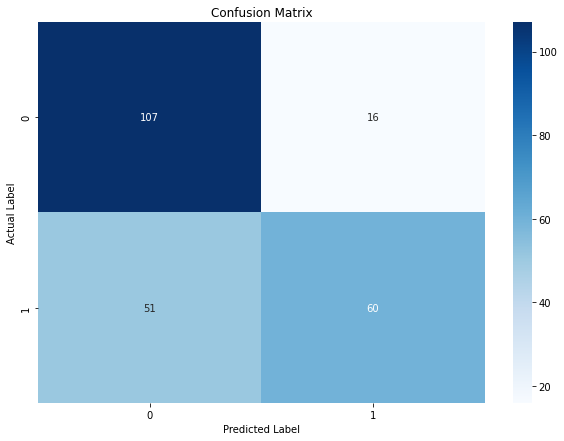

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
probabilities = torch.softmax(torch.tensor(test_results.predictions).to(torch.float32), dim=-1)
predictions = np.argmax(probabilities.numpy(), axis=1)
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [25]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = dataset['test'][idx]
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/5.1.5_results.csv', index=False)

In [26]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [27]:
correct_classification_counts

General Health           42
Bone health              16
Fitness                  11
Skin                     11
Diabetes                 10
Cancer                   10
Hair                      9
Eye                       9
Cardiovascular Health     8
Throat                    7
Ear                       6
Blood                     5
COVID                     5
Men's health              4
Women' s Health           4
Mental Health             3
Neurological health       3
Muscles                   2
Vascular                  2
Name: Category, dtype: int64

In [28]:
misclassification_counts

Skin                     13
General Health            9
Neurological health       6
Bone health               5
Cardiovascular Health     4
Muscles                   4
Blood                     4
Fitness                   4
Dental Health             3
Hair                      3
Diabetes                  2
Men's health              2
Throat                    2
Cancer                    2
Women' s Health           2
Vascular                  1
COVID                     1
Name: Category, dtype: int64

In [29]:
total_counts = df['Category'].value_counts()

# Calculate ratios
correct_classification_ratios = correct_classification_counts / total_counts
misclassification_ratios = misclassification_counts / total_counts

In [30]:
print(correct_classification_ratios)

Blood                    0.555556
Bone health              0.761905
COVID                    0.833333
Cancer                   0.833333
Cardiovascular Health    0.666667
Dental Health                 NaN
Diabetes                 0.833333
Ear                      1.000000
Eye                      1.000000
Fitness                  0.733333
General Health           0.823529
Hair                     0.750000
Men's health             0.666667
Mental Health            1.000000
Muscles                  0.333333
Neurological health      0.333333
Skin                     0.458333
Throat                   0.777778
Vascular                 0.666667
Women' s Health          0.666667
Name: Category, dtype: float64


In [31]:
print(misclassification_ratios)

Blood                    0.444444
Bone health              0.238095
COVID                    0.166667
Cancer                   0.166667
Cardiovascular Health    0.333333
Dental Health            1.000000
Diabetes                 0.166667
Ear                           NaN
Eye                           NaN
Fitness                  0.266667
General Health           0.176471
Hair                     0.250000
Men's health             0.333333
Mental Health                 NaN
Muscles                  0.666667
Neurological health      0.666667
Skin                     0.541667
Throat                   0.222222
Vascular                 0.333333
Women' s Health          0.333333
Name: Category, dtype: float64
